# Random Forest Classification (RFC)
* SACFOR percent cover for validation
* Headwall Hyperspectral
* aided by: 
https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

## Import packages

In [26]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import sample
from rasterio.warp import reproject, Resampling
import rasterio.mask
from rasterio.plot import show

import datetime

from skimage import exposure
from shapely.geometry import box
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import contextily as ctx

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import MinMaxScaler

from imblearn.ensemble import BalancedRandomForestClassifier

from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

# import xgboost as xgb

### Change working directory

In [9]:
os.chdir('/Users/Meredith/Library/CloudStorage/GoogleDrive-meredith.mcpherson@umb.edu/.shortcut-targets-by-id/1PJamAGTknM_kuVq8M53Xo4cAlWzDOk6I/kelp_murep/rs_imagery_processing/classification/random_forest')

datestring = datetime.datetime.now().date().strftime('%y%m%d')

## Datasets

In [119]:
# load the sacfor training data shape file
sacfor = gpd.read_file('data/dropcam/gooseberries_sacfor_v2.shp')

# bathymetry tif file
bathy_file = 'data/lidar/2022_ngs_topobathy_chatham_ma_Job964557_reproj.tif'

# rugosity tif file
rug_file = 'data/sidescan/rugosity/Gooseberry_Rugosity_reproj.tif'

# slope tif file
slope_file = 'data/sidescan/slope/Gooseberry_Slope_reproj.tif'

# hyperspectral tif file
img_file = 'data/headwall/nano_Rrs_deglint_smooth_mosaic_mean_v2_getisord.tif'

# wavelength data
wl = pd.read_csv('data/Headwall/wv_v2.csv', names = ['number','wl'])



## Validation GeoDF edit

In [94]:
sacfor['SACFOR_veg'] = sacfor['SACFOR_veg'].replace('s', 'S')

# Create a new column based on the elevations
z_thresh = -4
sacfor['depth criteria'] = np.where(sacfor['Elev(m)'] >= z_thresh, 'shallow', 'deep')

# create a new column based on presence and absence of kelp via some SACFOR % cover threshold
sacfor['kelp_pres/abs'] = np.where((sacfor['kel #'] == 3)| (sacfor['kel #'] == 4) | (sacfor['kel #'] == 5),1,0)
sacfor['veg_pres/abs'] = np.where((sacfor['veg #'] == 3) | (sacfor['veg #'] == 4) | (sacfor['veg #'] == 5),1,0)
sacfor['veg_corr_pres/abs'] = np.where((sacfor['veg #corr'] == 3) | (sacfor['veg #corr'] == 4) | (sacfor['veg #corr'] == 5),1,0)
# create column to reduce to fewer classes
sacfor['kelp_new_class'] = np.where(sacfor['kel #'].isin([0,1,2,3]), 0, np.where(sacfor['kel #'].isin([4]), 1, np.where(sacfor['kel #'].isin([5]), 2, np.nan)))
sacfor['veg_new_class'] = np.where(sacfor['veg #'].isin([0,1,2,3]), 0, np.where(sacfor['veg #'].isin([4]), 1, np.where(sacfor['veg #'].isin([5]), 2, np.nan)))



Sort sacfor shapefile for NODATA value in image raster

In [95]:
with rasterio.open(img_file) as src:
    tmp_arr = src.read()

# change the sacfor crs to match image
sacfor = sacfor.to_crs(src.crs)
    
# Create a list to store raster values for each point
raster_values = []

# Loop through each point in the GeoDataFrame
for index, point in sacfor.iterrows():
    
    # Get the coordinates of the point
    x, y = point['geometry'].x, point['geometry'].y

    # Convert point coordinates to pixel coordinates in the raster
    row, col = src.index(x, y)

    # Extract raster value at the pixel coordinates
    try:
        value = tmp_arr[50, row, col]  # Just get one band
    except IndexError:
        value = -9999.0

    # Append the value to the list
    raster_values.append(value)

# Add the extracted values as a new column in the GeoDataFrame
sacfor['spectral value'] = raster_values
sacfor = sacfor[sacfor['spectral value'] != src.nodata]

## Subset and mask deep water in the Headwall imagery

1. Crop the bathymetry file to the headwall bounding box
2. Crop the sacfor shapefile to the headwall bounding box
3. Mask deeper than the chosen depth threshold
4. Crop everything to the smaller subset area in north gooseberries

In [96]:
# Define the bounding box to crop to (xmin, ymin, xmax, ymax)

# CRS.from_epsg(26986)
# gb_subset_bbox = [258025, 919500, 258150, 919650]


# CRS.from_epsg(32619)
# gb_subset_bbox = [352664.3381461279, 4709500.633945491, 352793.6858460658, 4709654.231824983]

# NS flight lines
gb_subset_bbox = [src.bounds[0],src.bounds[1],352855,src.bounds[3]]

In [97]:
# Crop and mask everything

# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    arr_nanmasked = src.read(masked=True)
    
    meta = src.meta
    
    # HEADWALL BBOX
    # get the bounding corners and create window for the headwall src
    headwall_bbox = src.bounds
    headwall_bbox = [headwall_bbox.left, 
                     headwall_bbox.bottom, 
                     headwall_bbox.right, 
                     headwall_bbox.top]

    headwall_window = rio.windows.from_bounds(*headwall_bbox, 
                                              transform=meta['transform'])
        
    # convert the sacfor dataframe to the hyperspectral crs
    sacfor = sacfor.to_crs(src.crs)
    
    # crop sacfor to headwall bbox
    sacfor_headwall = sacfor[sacfor.within(box(*headwall_bbox))]
    
    # Open the reprojected file in read mode and read the data
    with rio.open(bathy_file) as bathy:
        bathy_arr = bathy.read(1,masked=True)
        bathy_arr[bathy_arr >= 0] = src.nodata
        bathy_arr[arr[50,:,:] == src.nodata] = src.nodata
        
        bathy_arr_mask = bathy_arr == src.nodata
        bathy_arr_nanmask = np.ma.masked_array(bathy_arr,
                                               bathy_arr_mask)

        # open slope
        with rio.open(slope_file) as slope:
            slope_arr = slope.read(1,masked=True)
            slope_arr[arr[50,:,:] == src.nodata] = src.nodata
            slope_arr_nanmasked = np.ma.masked_array(slope_arr,
                                                     bathy_arr_mask)
            # slope_arr_nanmasked = slope.read(1,masked=True)
            
            with rio.open(rug_file) as rug:
                rug_arr = rug.read(1,masked=True)
                rug_arr[arr[50,:,:] == src.nodata] = src.nodata
                rug_arr_nanmasked = np.ma.masked_array(rug_arr,
                                                       bathy_arr_mask)
                
                
                # check bounds to see if they match with imagery
                if (src.bounds == bathy.bounds == slope.bounds == rug.bounds) == False:

                    # crop the bathymetry data to the headwall bbox
                    bathy_headwall = bathy.read(window=headwall_window)[0]

                    slope_headwall = slope.read(window==headwall_window)[0]
                    
                    rug_headwall = rug.read(window==headwall_window)[0]

                    # Mask the headwall array where the values are greater than -4 or nan
                    nanmask = bathy_headwall == src.nodata
                    arr_nanmasked = np.ma.masked_array(arr, 
                                                       mask=np.tile(nanmask, (arr.shape[0], 1, 1)))

                    zmask = bathy_arr < z_thresh
                    arr_zmasked = np.ma.masked_array(arr_nanmasked, 
                                                     mask=np.tile(zmask, (arr.shape[0], 1, 1)))

                else:
                    # ----- SUBSET BBOX
                    # create window for subset
                    subset_window = rio.windows.from_bounds(*gb_subset_bbox, 
                                                            transform=meta['transform'])

                    # crop the headwall array to the subset bbox
                    arr_subset = src.read(window=subset_window)

                    # crop the bathymetry data to the subset bbox
                    bathy_subset = bathy.read(window=subset_window)[0]
                    bathy_subset[bathy_subset == bathy.nodata]= src.nodata
                    bathy_subset[bathy_subset >= 0] = src.nodata
                    bathy_subset[arr_subset[50,:,:] == src.nodata] = src.nodata

                    # crop the slope data to the subset bbox
                    slope_subset = slope.read(window=subset_window)[0]
                    slope_subset[slope_subset == slope.nodata]= src.nodata
                    slope_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
                    
                    
                    # crop the rugosity data to the subset bbox
                    rug_subset = rug.read(window=subset_window)[0]
                    rug_subset[rug_subset == rug.nodata]= src.nodata
                    rug_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
                    

                    # Filter sacfor points within the subset bounding box
                    sacfor_subset = sacfor[sacfor.within(box(*gb_subset_bbox))]

                    # sort out deep elevation in SACFOR
                    sacfor_subset_filt = sacfor_subset[sacfor_subset['Elev(m)']>=z_thresh]

                    # Mask the subset array where the values are greater than -4 or nan

                    # nanmask = np.isnan(bathy_subset)
                    nanmask = bathy_subset == src.nodata
                    arr_subset_nanmasked = np.ma.masked_array(arr_subset,
                                                              mask=np.tile(nanmask, (arr_subset.shape[0], 1, 1)))
                    bathy_subset_nanmasked = np.ma.masked_array(bathy_subset, 
                                                                mask=nanmask)
                    
                    nanmask_slope = slope_subset == src.nodata
                    slope_subset_nanmasked = np.ma.masked_array(slope_subset, 
                                                                mask=nanmask_slope)
                    
                    nanmask_rug = rug_subset == src.nodata
                    rug_subset_nanmasked = np.ma.masked_array(rug_subset, 
                                                              mask=nanmask_rug)

                    zmask = bathy_subset < z_thresh
                    arr_subset_zmasked = np.ma.masked_array(arr_subset_nanmasked, 
                                                            mask=np.tile(zmask, 
                                                                         (arr_subset.shape[0], 1, 1)))
                    bathy_subset_zmasked = np.ma.masked_array(bathy_subset_nanmasked,
                                                              mask = zmask)
                    
                    slope_subset_zmasked = np.ma.masked_array(slope_subset_nanmasked,
                                                              mask = zmask)
                    rug_subset_zmasked = np.ma.masked_array(rug_subset_nanmasked,
                                                            mask = zmask)

#### Mask deep water

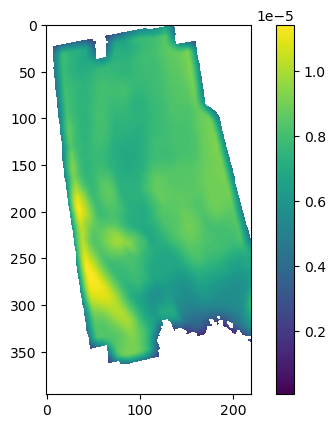

In [17]:
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

outfile = img_file[:-4]+'_NS.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(arr_subset_nanmasked)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[50,:,:])
plt.colorbar()

#### Rasterize the SACFOR for RF runs

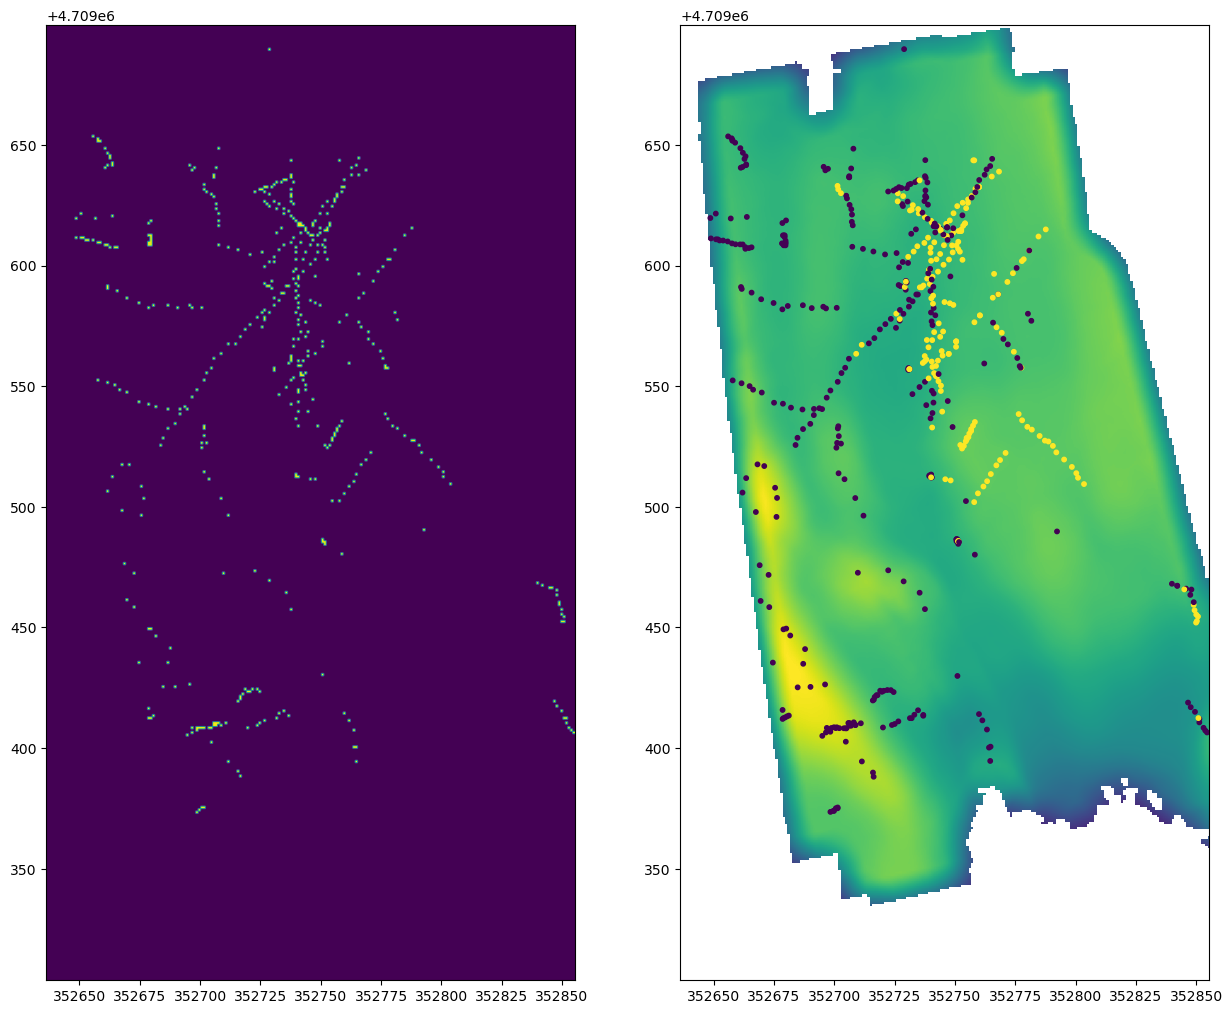

In [98]:
# rasterize the sacfor gpd to the cropped bounding box based on the 'sacfor_veg target
# as the values in the sacfor raster
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "dtype": 'int32'
})

# updated sacfor file with bathymetry from Lidar data
file = 'data/dropcam/gooseberries_sacfor_v2_subset_v2.shp'
sacfor_data = gpd.read_file(file)

# sacfor_data = sacfor_data[sacfor_data['Elev(m)']>=z_thresh]

# Names
sacfor_raster_names = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data.index)],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

# BINARY SACFOR 
sacfor_raster_binveg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg_pres/a'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_binkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_pres/'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# COMBINED SACFOR CLASSES
sacfor_raster_fewveg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg_new_cl'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_fewkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_new_c'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# FULL SACFOR 
sacfor_raster_veg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_kelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kel #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

# Check transforms match up

fig1, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,15))
     
show(sacfor_raster_names,
     transform = out_meta['transform'],
              ax=ax1)
# s = sacfor_subset.plot(ax=ax1, 
#                             column='kelp_new_class', 
#                             markersize = 10,
#                            edgecolor='k')
                            

show(arr_subset_nanmasked[50,:,:],
     transform = out_meta['transform'],
              ax=ax2)
s = sacfor_data.plot(ax=ax2, 
            column='kelp_pres/', 
            markersize = 10)


#### Figure for entire Gooseberry Headwall area with SACFOR overlayed

In [ ]:
# import shapefile for mass coastline
# mass coastline shapefile
mass = gpd.read_file('/Users/Meredith/Desktop/massgis-coast25k-arc-shapefile/GISDATA_COAST25K_ARC.shp')
mass = mass.to_crs(src.crs)
mass.plot()

# Create a bounding box from the raster bounds
bbox = src.bounds

# Subset the coastline to the extent of the raster
mass_subset = mass.cx[bbox.left:bbox.right, bbox.bottom:bbox.top]

mass_subset.plot()

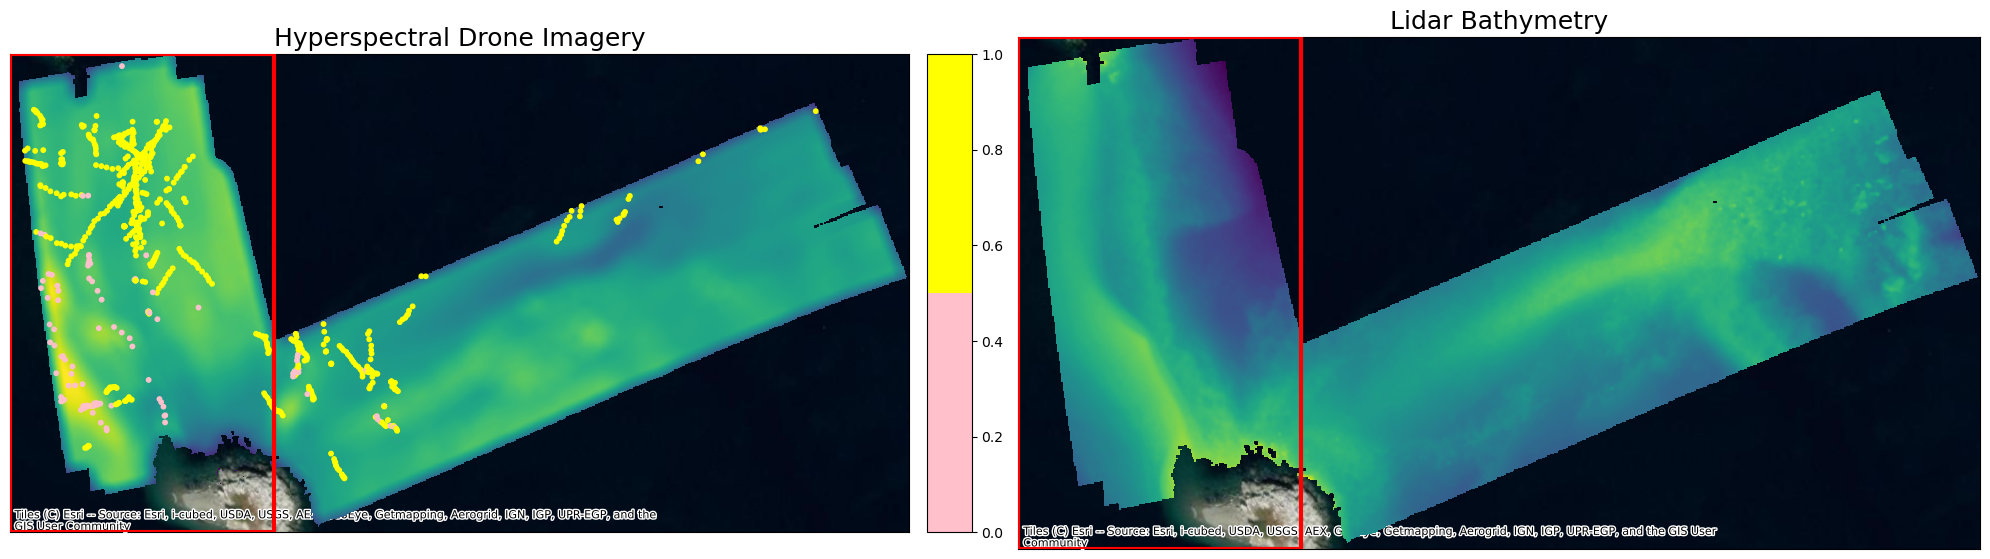

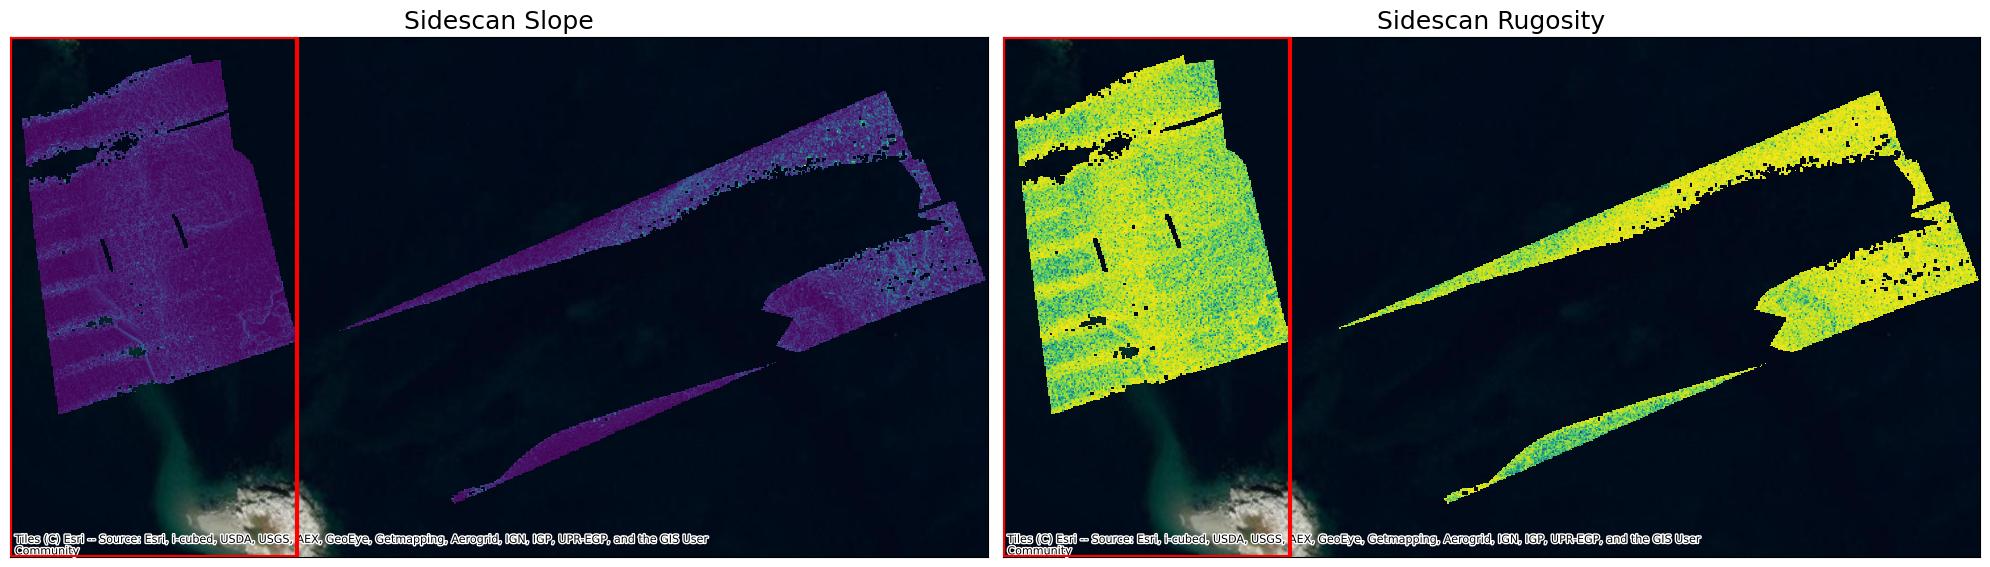

In [99]:
# create RGB


corr_rgb = arr[[120, 70, 25], :, :]
corr_rgb[corr_rgb < 0] = np.nan

# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)


# Plot the figure
fig1, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 20))

# rgb + sacfor

# rgb_im = show(gamma_corrected, 
#      transform = rio.windows.transform(headwall_window, src.transform),
#      ax=ax2)
rgb_im = show(arr_nanmasked[50,:,:], 
             transform = rio.windows.transform(headwall_window, src.transform),
              zorder=10,
             ax=ax1)
im = rgb_im.get_images()[0]

# sacfor colorbar
# Define the colors for 0 and 1
colors = ['pink', 'yellow']

# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')

s = sacfor_headwall.plot(ax=ax1, 
                           column='veg_pres/abs', 
                           markersize=10,
                            legend = True,
                            cax=cax,
                         zorder=21,
                            #legend_kwds={"label": "Vegetation", "orientation": "vertical"},
                           cmap = cmap)

ax1.set_title(f'Hyperspectral Drone Imagery',
              fontsize=18)# < {z_thresh} m')


rect2 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)

ax1.add_patch(rect2)

ctx.add_basemap(ax1, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax2.set_xticks([])
ax2.set_yticks([])


# bathymetry
# Overlay the red box
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax2.add_patch(rect1)




rio_im = show(bathy_arr_nanmask,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax2)
im = rio_im.get_images()[0]

ax2.set_title('Lidar Bathymetry', 
              fontsize = 18)
ctx.add_basemap(ax2, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax1.set_xticks([])
ax1.set_yticks([])

# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar1 = fig1.colorbar(im, cax=cax1)
# cbar1.set_label('Elevation (m)')


fig1.tight_layout()
# fig1.savefig('output/figs/headwall_bathy_rasters.png',dpi=300)
plt.show()



#######################
# Figure 2
#######################

fig2, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 20))
# Overlay the red box on the hyperspectral subplot
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                        edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax1.add_patch(rect1)

# slope

rio_im = show(slope_arr_nanmasked,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax1)
im = rio_im.get_images()[0]

ax1.set_title(f'Sidescan Slope',
              fontsize=18)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar2 = fig2.colorbar(im, cax=cax)
# cbar2.set_label(f'Slope ({chr(176)})')

ctx.add_basemap(ax1, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax1.set_xticks([])
ax1.set_yticks([])

###### rugosity

# Overlay the red box on the hyperspectral subplot
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax2.add_patch(rect1)

rio_im = show(rug_arr_nanmasked,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax2)
im = rio_im.get_images()[0]

ax2.set_title(f'Sidescan Rugosity',
              fontsize=18)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar3 = fig2.colorbar(im, cax=cax)
# cbar3.set_label(f'Rugosity')

ctx.add_basemap(ax2, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)

ax2.set_xticks([])
ax2.set_yticks([])

# tight layout and save
fig2.tight_layout()
# fig2.savefig('output/figs/slope_rugosity_rasters.png',dpi=300)
plt.show()

#### Figure for subset of Gooseberry Headwall area

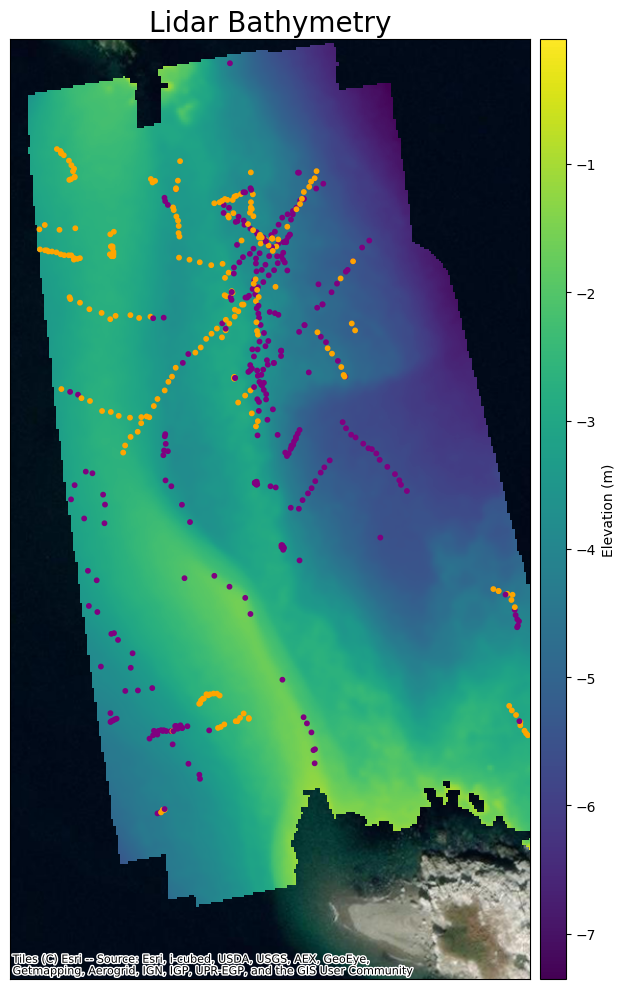

In [100]:
# create RGB

# full spectral resolution 
corr_rgb = arr_subset_nanmasked[[114, 75, 25], :, :]


# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

fig2, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))

# bathymetry
rio_im = show(bathy_subset_nanmasked, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              ax=ax1,
              cmap='viridis',
             zorder=10)
im = rio_im.get_images()[0]
ax1.set_title('Lidar Bathymetry',fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])


# bathymetry colorbar

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar1 = fig1.colorbar(im, cax=cax1)
cbar1.set_label('Elevation (m)')

# Define the colors for 0 and 1
colors = ['purple', 'orange']

# # Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar = fig1.colorbar(im, 
#                      cax=cax)
# cbar.set_label('Elevation (m)')
s = sacfor_subset.plot(ax=ax1, 
                        column='veg_corr_pres/abs', 
                        markersize=10,
                        # legend = True,
                        # cax=cax,
                       # legend_kwds={"label": "Kelp", "orientation": "vertical"},
                        cmap = cmap,
                      zorder=11)
# Add a basemap using contextily
# ctx.add_basemap(ax1, crs=sacfor_subset.crs, source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax1, crs=sacfor_subset.crs, source=ctx.providers.Esri.WorldImagery)



# rgb + sacfor plot
# rgb_im = show(gamma_corrected, 
#               transform = rio.windows.transform(subset_window, src.transform), 
#               ax=ax2)
# rgb_im = show(arr_subset[50,:,:], 
#               transform = rio.windows.transform(subset_window, src.transform), 
#               ax=ax2)
# im = rgb_im.get_images()[0]

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# s = sacfor_subset.plot(ax=ax2, 
#                            column='kelp_pres/abs', 
#                            markersize=10,
#                             legend = True,
#                             cax=cax,
#                             legend_kwds={"label": "Kelp Pres/Abs", "orientation": "vertical"},
#                            cmap = 'viridis')


# ax2.set_title(f'Headwall RGB < {z_thresh} m')

# ax2.set_xticks([])
# ax2.set_yticks([])

fig2.tight_layout()
# fig2.savefig('output/figs/bathy_with_veg.png',dpi=300)
plt.show()


## Vegetation Classifier

### Dimensionality Reduction - PCA on Headwall 

In [101]:
#### check for nans in hyperspectral data - cannot have for PCA

# full spectral resolution
arr_test = arr_subset

# create a boolean mask for NaN values
nan_mask = np.isnan(arr_subset_nanmasked)
nan_mask_test = np.isnan(arr_test)

# find the indices of NaN values
nan_indices = np.argwhere(nan_mask)
nan_indices_test = np.argwhere(nan_mask_test)

# visualize the NaN values using a scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# ax.scatter(nan_indices[:, 0], 
#            nan_indices[:, 1], 
#            nan_indices[:, 2], 
#            c=nan_indices[:, 0])
# ax.set_xlabel('Wavelength')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title('Full spectra all NaN wavelengths')
# plt.show()
                               
                              
# fig1 = plt.figure()
# ax = fig1.add_subplot(projection='3d')                               
# ax.scatter(nan_indices_test[:, 0], 
#            nan_indices_test[:, 1], 
#            nan_indices_test[:, 2], 
#            c=nan_indices_test[:, 0]) 
# ax.set_xlabel('Wavelength')
# ax.set_ylabel('X')
# ax.set_zlabel('Y')
# plt.title('Cropped spectra all NaN wavelengths')
# plt.show()


In [102]:

# stack the bathymetry and imagery arrays before flattening
bathy_reshape = np.reshape(bathy_subset_nanmasked,(1,bathy_subset_nanmasked.shape[0],bathy_subset_nanmasked.shape[1]))
arr_clean = np.ma.vstack((arr_subset_nanmasked,bathy_reshape))
# arr_clean = arr_subset_nanmasked

# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# add bathymetry data onto flattened data

# Perform PCA on the flattened data
pca = PCA(n_components = 10)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data_flattened = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data_flattened.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_nopca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


### Setting up data - Pairing X and y data

In [103]:
sacfor_type = sacfor_raster_binveg

n_samples = (sacfor_type >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_type[sacfor_type >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

# get the spectra and depth to put into the model
predictors = arr_clean_nopca[sacfor_type >= 0,:]

# We will need a "X" matrix containing our features, and a "y" array containing our labels
# These will have n_samples rows
X = predictors

# X with pca only 
# X = pca_data[sacfor_type >= 0,:]

# y
# y = sacfor_type[sacfor_type >= 0]

# y removing NaN from depth
y = sacfor_type[sacfor_type >= 0]#[~np.isnan(X).any(axis=1)]

# get the ID for the names so that it can be added to a results df later
names = sacfor_raster_names[sacfor_type >= 0]#[~np.isnan(X).any(axis=1)]

# # scale X
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# split up the dataset to training and validation with stratification
train_X, val_X, train_y, val_y, train_names, val_names = train_test_split(
    X, y, names,
    test_size=0.2,
    random_state=1,
    stratify=y  # Ensure stratified split based on 'y'
)


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 472 samples
The training data include 2 classes: [0 1]
Our X matrix is sized: (472, 182)
Our y array is sized: (472,)


### Hypertuning Random Forest and XGBoost Models 
1. https://www.kaggle.com/code/virajbagal/eda-xgb-random-forest-parameter-tuning-hyperopt/notebook
2. https://github.com/hyperopt/hyperopt-sklearn
3. https://machinelearningmastery.com/hyperopt-for-automated-machine-learning-with-scikit-learn/

#### Hypertuning model with Hyperopt Estimator - do not use!


In [28]:
rf_model = HyperoptEstimator(classifier=random_forest_classifier('RF1'),
                              preprocessing=any_preprocessing('pre'))


rf_model.fit(train_X,train_y)

NameError: name 'HyperoptEstimator' is not defined

In [843]:
acc = rf_model.score(val_X,val_y) * 100
print(f'Accuracy: {acc:.3f}%')

print(rf_model.best_model())

Accuracy: 36.364%
{'learner': RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, max_features=0.14204273799356526,
                       max_leaf_nodes=15, n_estimators=78, n_jobs=1,
                       random_state=1, verbose=False), 'preprocs': (StandardScaler(with_mean=False, with_std=False),), 'ex_preprocs': ()}


#### Hypertuning with GridSearchCV - do not use!
1. https://www.youtube.com/watch?v=f20fU6so580

In [158]:
from sklearn.model_selection import GridSearchCV
model_params = {
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [10,50,100,150,500],
            'max_features': [0.33, 1,5, 'sqrt', 'log2',None],
            'criterion': ['gini','entropy','log_loss'],
            'random_state': [None, 0, 1, 2,3],
            
            
        }
    },
    }


scores = []

for model_name, mp in model_params.items():
    grid =  GridSearchCV(estimator=mp['model'], 
                         param_grid=mp['params'], 
                         cv=5, n_jobs=3, 
                         return_train_score=False)
    
    grid.fit(train_X, train_y)
    
    scores.append({
        'model': model_name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })

import pandas as pd    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

print(df)

           model  best_score  \
0  random_forest    0.768393   

                                         best_params  
0  {'criterion': 'entropy', 'max_features': 1, 'n...  


Random Forest Hypertuning

#### Hypertuning with Hyperopt

In [133]:
# Random Forest Hypertuning 
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestClassifier(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=mean_squared_error(val_y,pred)
    return score

def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',3,8),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=500,rstate=np.random.default_rng(seed))
    return best

trial_rf=Trials()
best_rf=optimize(trial_rf)



100%|████████████████████████████████████████████████████████| 500/500 [03:45<00:00,  2.22trial/s, best loss: 0.4909090909090909]


In [134]:
print(f'Random Forest best: {best_rf}')

Random Forest best: {'max_depth': 5.101208054194201, 'min_samples_leaf': 4.362404654862145, 'min_samples_split': 5.650447965353443, 'n_estimators': 180.12943857883053}


XGBoost Hypertuning

In [135]:
# XGBoost Hypertuning

seed=5
def objective2(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    learning=params['learning_rate']
    
    
    model=xgb.XGBRegressor(n_estimators=est,max_depth=md,learning_rate=learning)
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=mean_squared_error(val_y,pred)
    return score

def optimize2(trial):
    params={'n_estimators':hp.uniform('n_estimators',100,500),
           'max_depth':hp.uniform('max_depth',3,8),
           'learning_rate':hp.uniform('learning_rate',0.01,0.2)}
    best2=fmin(fn=objective2,space=params,algo=tpe.suggest,trials=trial,max_evals=500,rstate=np.random.default_rng(seed))
    return best2

trial_xgb=Trials()
best_xgb=optimize2(trial_xgb)

100%|████████████████████████████████████████████████████████| 500/500 [02:09<00:00,  3.86trial/s, best loss: 0.3978037248768712]


In [35]:
print(f'XGBoost Best: {best_xgb}')

XGBoost Best: {'learning_rate': 0.1673804020834057, 'max_depth': 3.1759324919410377, 'n_estimators': 353.93672462577825}


### Random Forest Classifier

In [104]:
# Initialize our model with hypertuned parameters
# rf = RandomForestClassifier(n_estimators=int(best_rf['n_estimators']),
#                             max_depth = int(best_rf['max_depth']), 
#                             min_samples_leaf=int(best_rf['min_samples_leaf']),
#                             min_samples_split=int(best_rf['min_samples_split']),
#                             random_state=1, 
#                             oob_score=True)

rf = BalancedRandomForestClassifier(oob_score=True)

# Fit our model to training data
rf = rf.fit(train_X, train_y)



/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set

What is the RF model accuracy?


OOB Accuracy: 92.31% 

Accuracy Score: 95.79% 

Cohen Kappa: 86.30% 

col_0   0   1  All
row_0             
0      16   1   17
1       3  75   78
All    19  76   95

MSE: 0.04


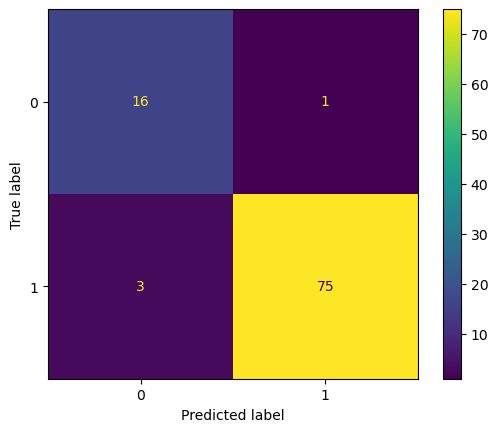

In [105]:
# mean squared error:
# Predict X values
y_pred_rf = rf.predict(val_X)

# out-of-box score - subset of training set
oob=rf.oob_score_ * 100
print(f'\nOOB Accuracy: {oob:.2f}% \n')

# Validation score - sa
score_rf = rf.score(val_X,val_y) * 100
score_rf = accuracy_score(val_y,y_pred_rf) * 100
print(f'Accuracy Score: {score_rf:.2f}% \n')

kappa_rf = cohen_kappa_score(val_y,y_pred_rf) * 100
print(f'Cohen Kappa: {kappa_rf:.2f}% \n') 

# Cross-tabulate predictions
print(pd.crosstab(val_y, y_pred_rf, margins=True))
cm = ConfusionMatrixDisplay.from_estimator(rf, val_X, val_y)
cm.figure_.savefig(f'output/veg/{datestring}_veg_PA_BRFconfusion.png')

mse_rf = mean_squared_error(y_pred_rf,val_y)

print(f'\nMSE: {mse_rf:.2f}')

Characterizing misclassified spectra

0
1


/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_29271/3249729185.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


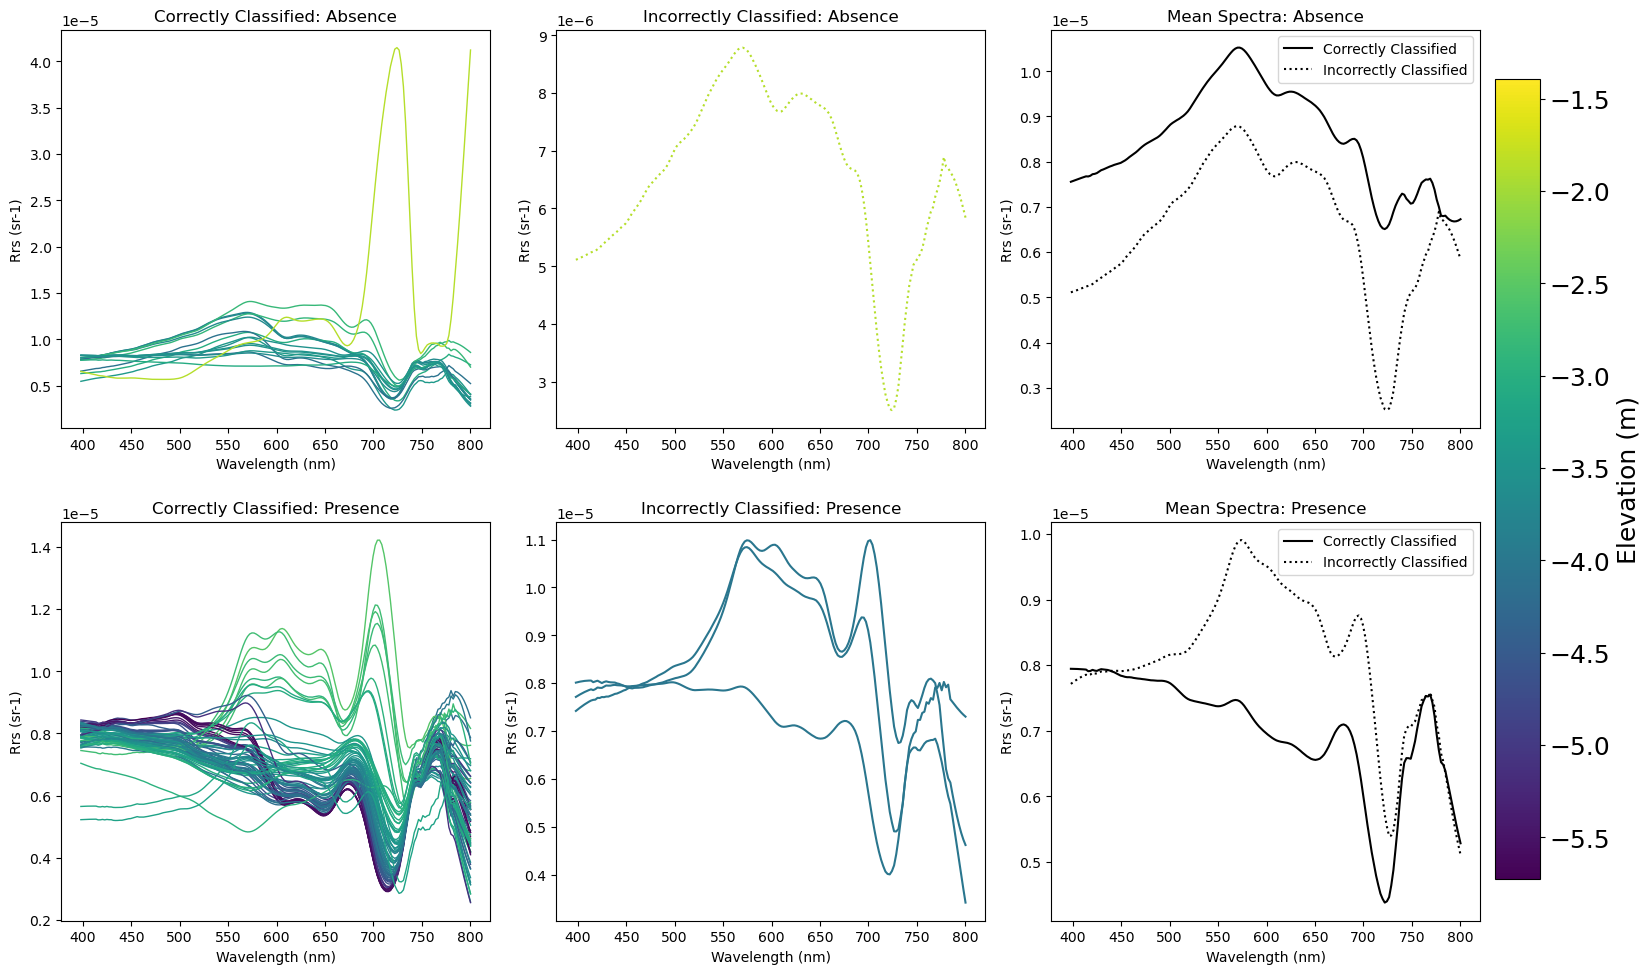

In [116]:
# Create a DataFrame with true labels, predicted labels, and features
results_df = pd.DataFrame({
    'Name': sacfor_data['Name'][val_names.tolist()],
    'True_Label': val_y,
    'Predicted_Label': y_pred_rf,
     'Depth': val_X[:, -1]
    # Add other features if needed
})

# Add a column indicating whether the prediction was correct
results_df['Correctly_Classified'] = results_df['True_Label'] == results_df['Predicted_Label']
results_df['Label_Difference'] = results_df['True_Label'] - results_df['Predicted_Label']
results_df.reset_index(inplace=True)

results_df.to_csv(f'output/{datestring}_veg_PA.csv')

num_classes = 2
label = ['Absence','Presence']
# label = ['Low', 'Medium', 'Dense']

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(num_classes, 3, figsize=(15, 5 * num_classes))

# create a ScalarMappable object for the color mapping
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=sacfor_data['Elev(m)'].min(), vmax=sacfor_data['Elev(m)'].max())

for val in range(num_classes):
    print(val)
    
    # Extract indices of correctly and incorrectly classified samples
    correct_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==True)].index
    incorrect_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==False)].index
    
    # Access corresponding features for correctly and incorrectly classified samples
    correctly_classified = val_X[correct_indices].T[:-1]
    incorrectly_classified = val_X[incorrect_indices].T[:-1]
    incorrectly_classified_val = results_df['Label_Difference'][incorrect_indices]
    depth = results_df['Depth'][correct_indices]
    
    correctly_classified_mean = np.mean(correctly_classified,axis=1)
    incorrectly_classified_mean = np.mean(incorrectly_classified,axis=1)

    '''
    plot it in a grid for each class where each row has three columns with 
    1. the correctly classified spectra (no color specification) 
    
    2. the incorrectly classified spectra (shade is based on sign value, 
    color is based on magnitude)
    
    3. the mean of the correctly and incorrectly labeled spectra (black solid for correct, 
    black dashed for incorrect)
    
    '''
    
    # Plotting the correctly classified spectra
    for e,el in enumerate(depth):
        axes[val, 0].plot(wl['wl'], correctly_classified[:,e], linewidth = 1,color=cmap(norm(el)))
    #axes[val, 0].plot(wl['wl'],correctly_classified,color=cmap(norm(depth)))
    axes[val, 0].set_title(f'Correctly Classified: {label[val]}')
    # axes[val, 0].set_ylim([0,0.015])
    axes[val, 0].set_xlabel('Wavelength (nm)')
    axes[val, 0].set_ylabel('Rrs (sr-1)')

    # Plotting the incorrectly classified spectra
    axes[val, 1].plot(wl['wl'],incorrectly_classified, color=cmap(norm(el)))
    
    # Customize line colors based on 'incorrectly_classified_val' sign
    for l,line in enumerate(axes[val, 1].lines):
        if incorrectly_classified_val.iloc[l] < 0:
            line.set_linestyle(':')
        else:
            line.set_linestyle('-')
    
    # update plot settings        
    axes[val, 1].set_title(f'Incorrectly Classified: {label[val]}')
    # axes[val, 1].set_ylim([0,0.015])
    axes[val, 1].set_xlabel('Wavelength (nm)')
    axes[val, 1].set_ylabel('Rrs (sr-1)')
    #axes[val, 1].legend(['overclassified','underclassified'])

    # Plotting the mean of correctly and incorrectly labeled spectra
    axes[val, 2].plot(wl['wl'],correctly_classified_mean, label='Correctly Classified',color='k')
    axes[val, 2].plot(wl['wl'],incorrectly_classified_mean, label='Incorrectly Classified',color='k',linestyle=':')
    # axes[val, 2].set_ylim([0,0.015])
    axes[val, 2].set_xlabel('Wavelength (nm)')
    axes[val, 2].set_ylabel('Rrs (sr-1)')
    axes[val, 2].set_title(f'Mean Spectra: {label[val]}')
    axes[val, 2].legend()

# add the colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.1, 0.03, 0.8])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Elevation (m)',fontsize=18)
cbar_ax.tick_params(labelsize=18)  

plt.tight_layout()
plt.show()
    
fig.savefig(f'output/veg/{datestring}_veg_BRF_PA_spectra.png')    

Band Importance

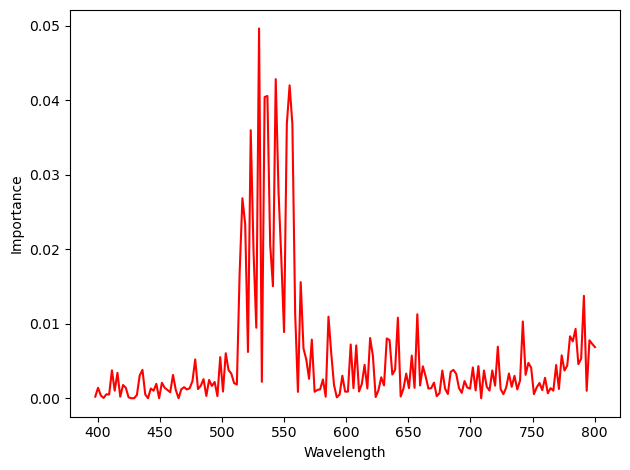

In [127]:
# band importance
bands = list(range(1, arr_clean_nopca.shape[2]))
importance = rf.feature_importances_

# for b, imp in zip(bands, importance):
#     print('Band {b} importance: {imp}'.format(b=b, imp=imp))

# create a dataframe with wl and importance together
# wl.loc[-1] = ['z',1]

impt = pd.DataFrame(columns = ['wl','importance'])
impt['wl'] = wl['wl']
impt['importance'] = importance[:-1]

n_largest_values = impt['importance'].nlargest(10)
top_wl = impt.loc[n_largest_values.index]['wl']

# plot band imporance
fig,(ax1) = plt.subplots()
# ax1.plot(new_wl['wl'],arr_clean[:,80,60])
# ax1.plot(new_wl['wl'],arr_clean[:,80,60])
# ax1_twin = ax1.twinx()
ax1.plot(impt.wl,impt.importance,c='r')
ax1.set_ylabel('Importance')
# ax1_twin.set_ylabel('Band Importance')
ax1.set_xlabel('Wavelength')
fig.tight_layout()

### XGBoost Classifier

In [625]:
import xgboost as xgb

# xg_model = xgb.XGBClassifier(learning_rate= best_xgb['learning_rate'], 
#                              max_depth = int(best_xgb['max_depth']), 
#                              n_estimators = int(best_xgb['n_estimators']),
#                              random_state=1)

xg_model = xgb.XGBClassifier()
xg_model.fit(train_X, train_y)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy Score: 95.79% 

col_0   0   1  All
row_0             
0      16   1   17
1       3  75   78
All    19  76   95


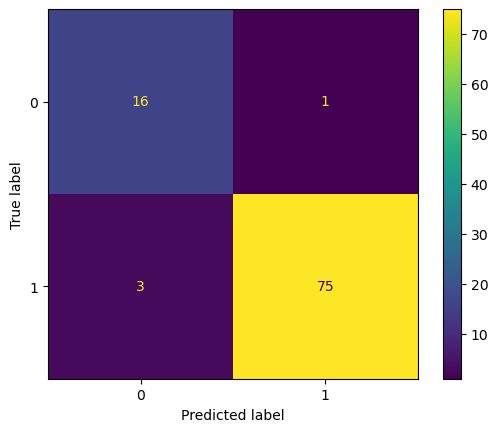

In [626]:
# mean squared error:
# Predict X values
y_pred_xgb = xg_model.predict(val_X)

# accuracy
score_xgb = accuracy_score(val_y,y_pred_xgb) * 100
print(f'Accuracy Score: {score_xgb:.2f}% \n')


# Cross-tabulate predictions
print(pd.crosstab(val_y, y_pred_xgb, margins=True))
ConfusionMatrixDisplay.from_estimator(xg_model, val_X, val_y)

### Predicting Vegetation the rest of the image

In [41]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
# use flattened_data var from above

# Now predict for each pixel
veg_prediction = rf.predict(flattened_data)
#class_prediction = rf.predict(pca_data_flattened)

# Reshape our classification map
veg_prediction_reshape = veg_prediction.reshape(arr_clean[0,:, :].shape)

# mask deep water
veg_prediction_mask = np.ma.masked_array(veg_prediction_reshape, mask=np.tile(nanmask, (1, 1, 1)))
# veg_prediction_mask = np.ma.masked_array(veg_prediction_mask, mask = zmask)

Plot the classification raster

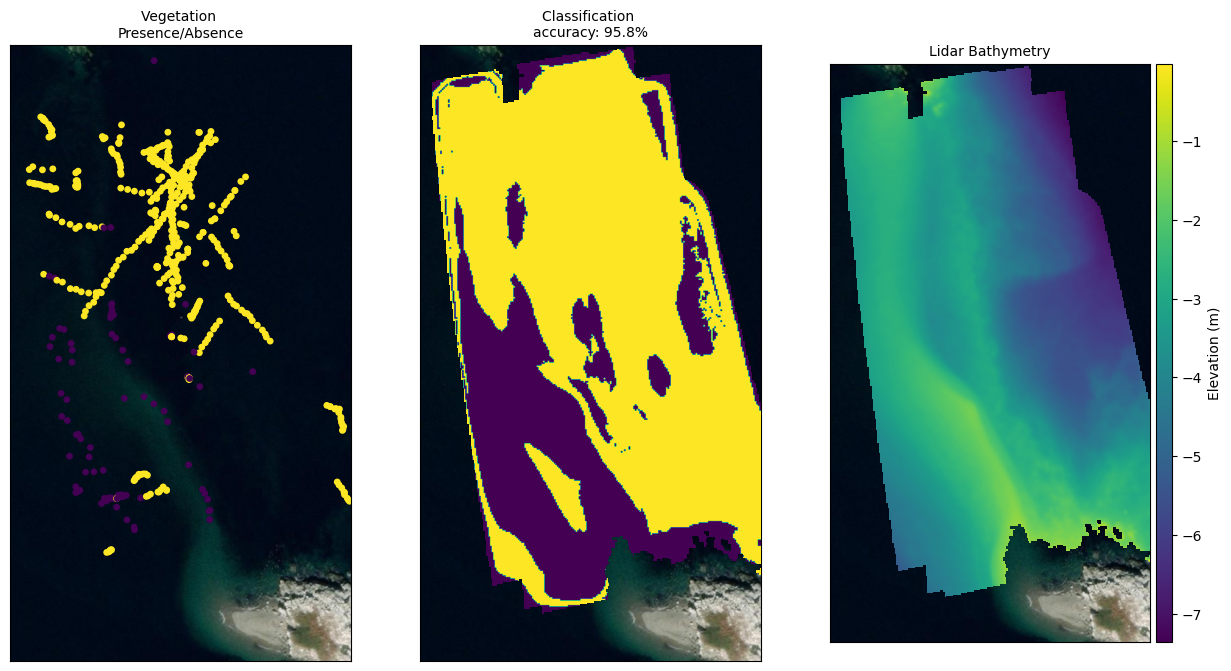

In [128]:
# See https://github.com/matplotlib/matplotlib/issues/844/
n = veg_prediction.max()

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting

# full spectral resolution
corr_rgb = arr_clean[[114, 75, 25], :, :]


gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 8))

show(gamma_corrected, 
     transform = rio.windows.transform(subset_window, src.transform), 
     ax=ax1)
ax1.set_title('Vegetation \nPresence/Absence',fontsize=10)
sacfor_data.plot(ax=ax1, 
            c=sacfor_data['veg_pres/a'], 
            markersize=15)

ctx.add_basemap(ax1, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)

ax1.set_xticks([])
ax1.set_yticks([])

pred_im = show(veg_prediction_mask,
                transform = rio.windows.transform(subset_window, src.transform),
               zorder=10,
                ax=ax2)
im_class = pred_im.get_images()[0]
# sacfor_subset_filt.plot(ax=ax2, 
#              c=sacfor_subset_filt['veg_new_class'], 
#              markersize=15)
ctx.add_basemap(ax2, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax2.set_title(f'Classification \naccuracy: {score_rf:.1f}%',fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])

# resize the colorbar to match the size of ax2
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad=0.1)
# cbar = fig.colorbar(im_class, 
#                     cax=cax, 
#                     cmap='viridis')
# cbar.ax.tick_params(labelsize=10)
# #cbar.set_ticks([0,1,2,3,4,5])
# # cbar.set_ticks([0,1,2])
# cbar.set_ticks([0,1])
# cbar.set_label('Cover Class')

rio_im = show(bathy_subset_nanmasked, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              zorder=10,
              ax=ax3,
              cmap='viridis')
im = rio_im.get_images()[0]
ctx.add_basemap(ax3, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax3.set_title('Lidar Bathymetry',fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


fig.savefig(f'output/veg/{datestring}_veg_PA.jpg')
plt.show()

Save the vegetation classification and bathymetry rasters as a tif

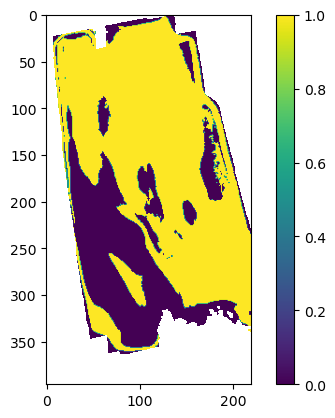

In [129]:
reshape_veg = veg_prediction_mask.reshape(1,veg_prediction_mask.shape[0],veg_prediction_mask.shape[1])

out_meta = src.meta.copy()
out_meta.update({
    "height": reshape_veg.shape[1],
    "width": reshape_veg.shape[2],
    "count": reshape_veg.shape[0],
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

outfile = f'output/veg/{datestring}_veg_BRF_PA_classification.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(reshape_veg)

with rio.open(outfile) as out_data:
    d = out_data.read(1)
    d[d<0]=np.nan

plt.imshow(d)
plt.colorbar()

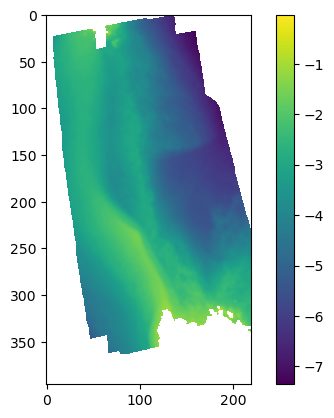

In [863]:
reshape_bathy = bathy_subset.reshape(1,bathy_subset.shape[0],bathy_subset.shape[1])

out_meta = src.meta.copy()
out_meta.update({
    "height": reshape_bathy.shape[1],
    "width": reshape_bathy.shape[2],
    "count": reshape_bathy.shape[0],
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

outfile = bathy_file[:-4]+'_NS.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(reshape_bathy)

with rio.open(outfile) as out_data:
    d = out_data.read(1)
    d[d==-9999.]=np.nan

plt.imshow(d)
plt.colorbar()

## Kelp Classifier

In [131]:
# Bare substrate mask
vegmask = veg_prediction_mask == 0
# depth_mask = (bathy_subset_nanmasked <= -3) & (bathy_subset_nanmasked > -4)

combined_mask = vegmask #| ~depth_mask

# mask everything
bathy_vegmask = np.ma.masked_array(bathy_subset_nanmasked, mask=combined_mask)
slope_vegmask = np.ma.masked_array(slope_subset_nanmasked, mask=combined_mask)
rug_vegmask = np.ma.masked_array(rug_subset_nanmasked, mask=combined_mask)
                                   
arr_subset_vegmask = np.ma.masked_array(arr_subset_nanmasked,mask=np.tile(combined_mask, (arr_subset.shape[0], 1, 1)))

# reshape the 2D arrays to 3D
bathy_reshape = np.reshape(bathy_vegmask,(1,bathy_vegmask.shape[0],bathy_vegmask.shape[1]))
slope_reshape = np.reshape(slope_vegmask,(1,slope_vegmask.shape[0],slope_vegmask.shape[1]))
rug_reshape = np.reshape(rug_vegmask,(1,rug_vegmask.shape[0],rug_vegmask.shape[1]))

### just spectra
arr_clean = arr_subset_vegmask

### stack the spectra + bathymetry (for depth)
# arr_clean = np.ma.vstack((arr_subset_vegmask,bathy_reshape))

### stack the spectra + bathymetry + slope + rugosity
# arr_clean = np.ma.vstack((arr_subset_vegmask,bathy_reshape,slope_reshape,rug_reshape))
# arr_clean = np.ma.masked_array(arr_clean,mask=np.tile(nanmask_slope, (arr_clean.shape[0], 1, 1)))
# arr_clean = np.ma.masked_array(arr_clean,mask=np.tile(nanmask_rug, (arr_clean.shape[0], 1, 1)))

In [132]:
file_str = 'getisord'
class_str = 'PA'

Update sacfor to only include valid data

In [133]:
# Create a list to store raster values for each point
raster_values = []

# Loop through each point in the GeoDataFrame
for index, point in sacfor_data.iterrows():
    
    # Get the coordinates of the point
    x, y = point['geometry'].x, point['geometry'].y

    # Convert point coordinates to pixel coordinates in the raster
    row, col = src.index(x, y)

    # Extract raster value at the pixel coordinates
    try:
        value = arr_clean[50, row, col]  # Just get one band
    except IndexError:
        value = -9999.0

    # Append the value to the list
    raster_values.append(value)

# Add the extracted values as a new column in the GeoDataFrame
sacfor_data['spectral value'] = raster_values
sacfor_data = sacfor_data[sacfor_data['spectral value'] != src.nodata]

Rasterize new sacfor file

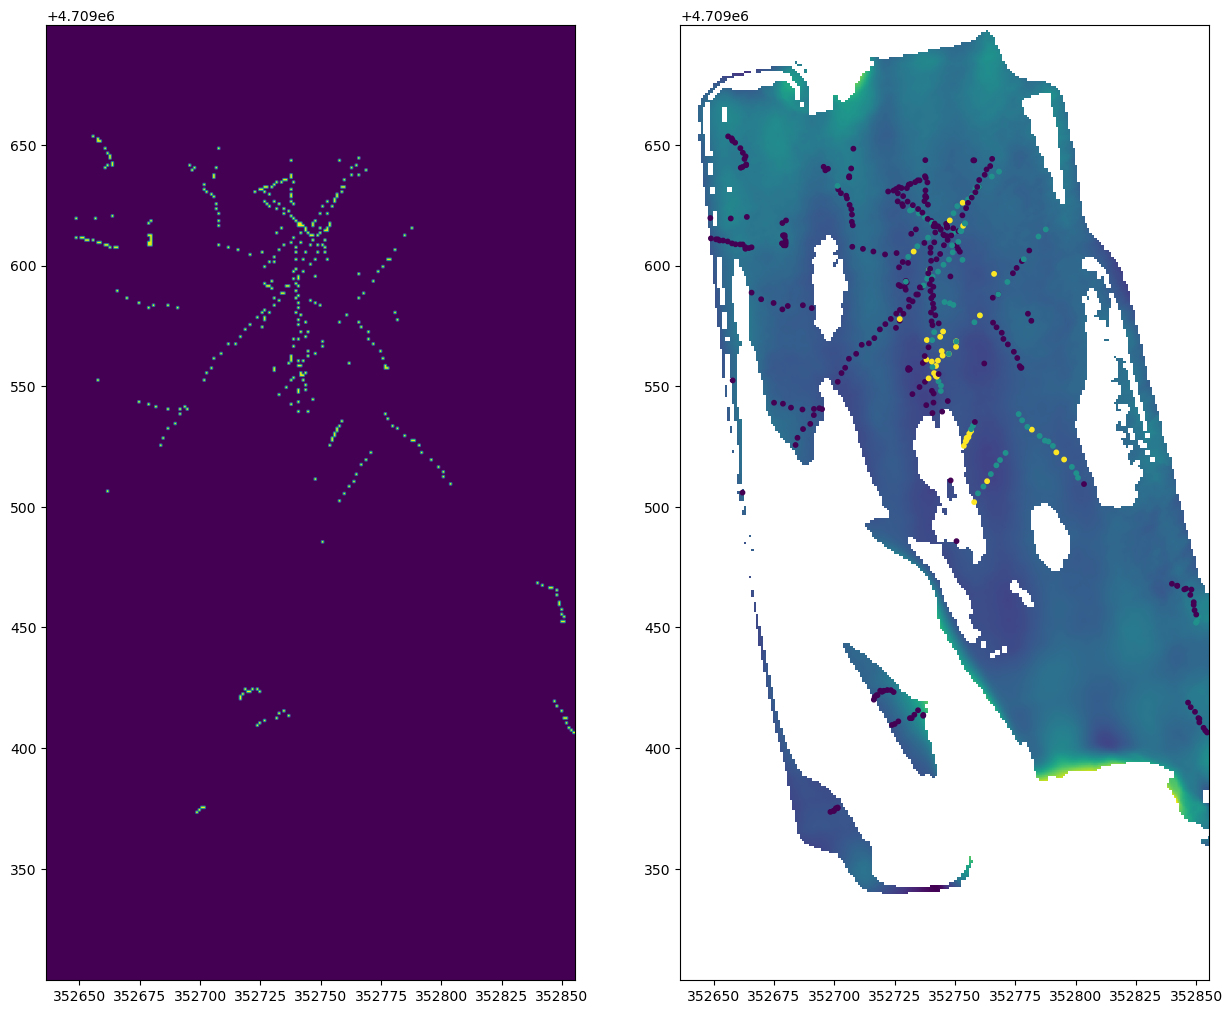

In [134]:
# rasterize the sacfor gpd to the cropped bounding box based on the 'sacfor_veg target
# as the values in the sacfor raster
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "dtype": 'int32'
})

sacfor_data = sacfor_data

# Names
sacfor_raster_names = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data.index)],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


sacfor_raster_binkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_pres/'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


sacfor_raster_fewkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_new_c'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# FULL SACFOR 
sacfor_raster_kelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kel #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

# Check transforms match up

fig1, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,15))
     
show(sacfor_raster_names,
     transform = out_meta['transform'],
              ax=ax1)
# s = sacfor_subset.plot(ax=ax1, 
#                             column='kelp_new_class', 
#                             markersize = 10,
#                            edgecolor='k')
                            

show(arr_clean[-3,:,:],
     transform = out_meta['transform'],
              ax=ax2)
s = sacfor_data.plot(ax=ax2, 
                            column='kelp_new_c', 
                            markersize = 10)


Dimensionality Reduction - PCA

In [135]:
# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# add bathymetry data onto flattened data

# Perform PCA on the flattened data
pca = PCA(n_components = 10)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data_flattened = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data_flattened.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_nopca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


Setting up data - Pairing X and y data

In [157]:
sacfor_type = sacfor_raster_binkelp

n_samples = (sacfor_type >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_type[sacfor_type >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

# get the data (spectra and depth)

raster_data = arr_clean_nopca[sacfor_type >= 0,:]

# We will need a "X" matrix containing our features, and a "y" array containing our labels
# These will have n_samples rows
X = raster_data

#scale the data
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# X with pca only 
# X = pca_data[sacfor_type >= 0,:]

# y
y = sacfor_type[sacfor_type >= 0]


# y removing NaN from depth
# y = sacfor_type[sacfor_type >= 0][~np.isnan(X_all).any(axis=1)]

# get the ID for the names so that it can be added to a results df later
names = sacfor_raster_names[sacfor_type >= 0][~np.isnan(X).any(axis=1)]


# split up the dataset to training and validation

# split up the dataset to training and validation with stratification
train_X, val_X, train_y, val_y, train_names, val_names = train_test_split(
    X, y, names,
    test_size=0.2,
    random_state=1,
    stratify=y  # Ensure stratified split based on 'y'
)


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 375 samples
The training data include 2 classes: [0 1]
Our X matrix is sized: (375, 181)
Our y array is sized: (375,)


### RF Classifier

In [1025]:
# Initialize our model with hypertuned parameters
# rf = RandomForestClassifier(n_estimators=int(best_rf['n_estimators']),
#                             max_depth = int(best_rf['max_depth']), 
#                             min_samples_leaf=int(best_rf['min_samples_leaf']),
#                             min_samples_split=int(best_rf['min_samples_split']),
#                             random_state=1, 
#                             oob_score=True)

rf = RandomForestClassifier(oob_score=True,bootstrap=True)#,class_weight={'balanced','balanced_subsample'})

# Fit our model to training data
rf = rf.fit(train_X, train_y)


RF Accuracy


OOB Accuracy: 63.33% 

Accuracy Score: 73.68% 

col_0   0   1  All
row_0             
0      19   4   23
1       6   9   15
All    25  13   38

MSE: 0.26


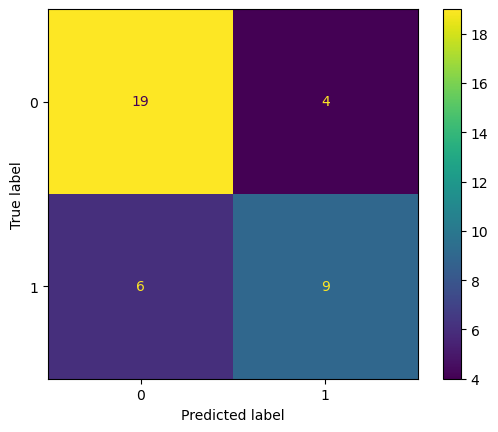

In [1026]:
# mean squared error:
# Predict X values
y_pred_rf = rf.predict(val_X)

# out-of-box score - subset of training set
oob=rf.oob_score_ * 100
print(f'\nOOB Accuracy: {oob:.2f}% \n')

# Validation score - sa
score_rf = rf.score(val_X,val_y) * 100
score_rf = accuracy_score(val_y,y_pred_rf) * 100
print(f'Accuracy Score: {score_rf:.2f}% \n')

# Cross-tabulate predictions
print(pd.crosstab(val_y, y_pred_rf, margins=True))
cm = ConfusionMatrixDisplay.from_estimator(rf, val_X, val_y)
cm.figure_.savefig(f'output/kelp/{datestring}_kelp_LMD_RFconfusion_{file_str}.jpg')

mse_rf = mean_squared_error(y_pred_rf,val_y)

print(f'\nMSE: {mse_rf:.2f}')

### Balanced RF Classifier

/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:576: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:588: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/Caskroom/miniforge/base/envs/geo/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:600: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set


OOB Accuracy: 79.67% 

Accuracy Score: 77.33% 

Kappa Score: 53.85% 

col_0   0   1  All
row_0             
0      34   9   43
1       8  24   32
All    42  33   75

MSE: 0.23


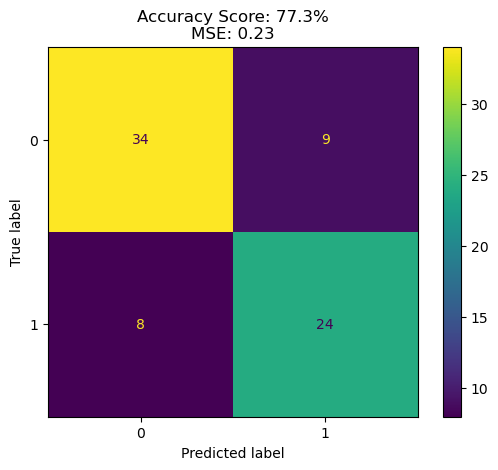

In [158]:
brf = BalancedRandomForestClassifier(oob_score=True)
brf = brf.fit(train_X, train_y)

# mean squared error:
# Predict X values
y_pred_brf = brf.predict(val_X)

# out-of-box score - subset of training set
oob=brf.oob_score_ * 100
print(f'\nOOB Accuracy: {oob:.2f}% \n')

# Validation score - sa
score_brf = brf.score(val_X,val_y) * 100
score_brf = accuracy_score(val_y,y_pred_brf) * 100
print(f'Accuracy Score: {score_brf:.2f}% \n')

kappa_brf = cohen_kappa_score(val_y,y_pred_brf) * 100
print(f'Kappa Score: {kappa_brf:.2f}% \n')

# mean square error
mse_brf = mean_squared_error(y_pred_brf,val_y)

# Cross-tabulate predictions
print(pd.crosstab(val_y, y_pred_brf, margins=True))
cm = ConfusionMatrixDisplay.from_estimator(brf, val_X, val_y)
cm.ax_.set_title(f'Accuracy Score: {score_brf:.1f}%'+f'\nMSE: {mse_brf:.2f}')
cm.figure_.savefig(f'output/kelp/{datestring}_kelp_{class_str}_BRFconfusion_{file_str}.jpg')




print(f'\nMSE: {mse_brf:.2f}')

### Characterizing misclassified spectra

In [159]:
pred_label = y_pred_brf

0
1


/var/folders/69/6d1c0dr57w3c_dskwr2955mh0000gq/T/ipykernel_29271/2248868061.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


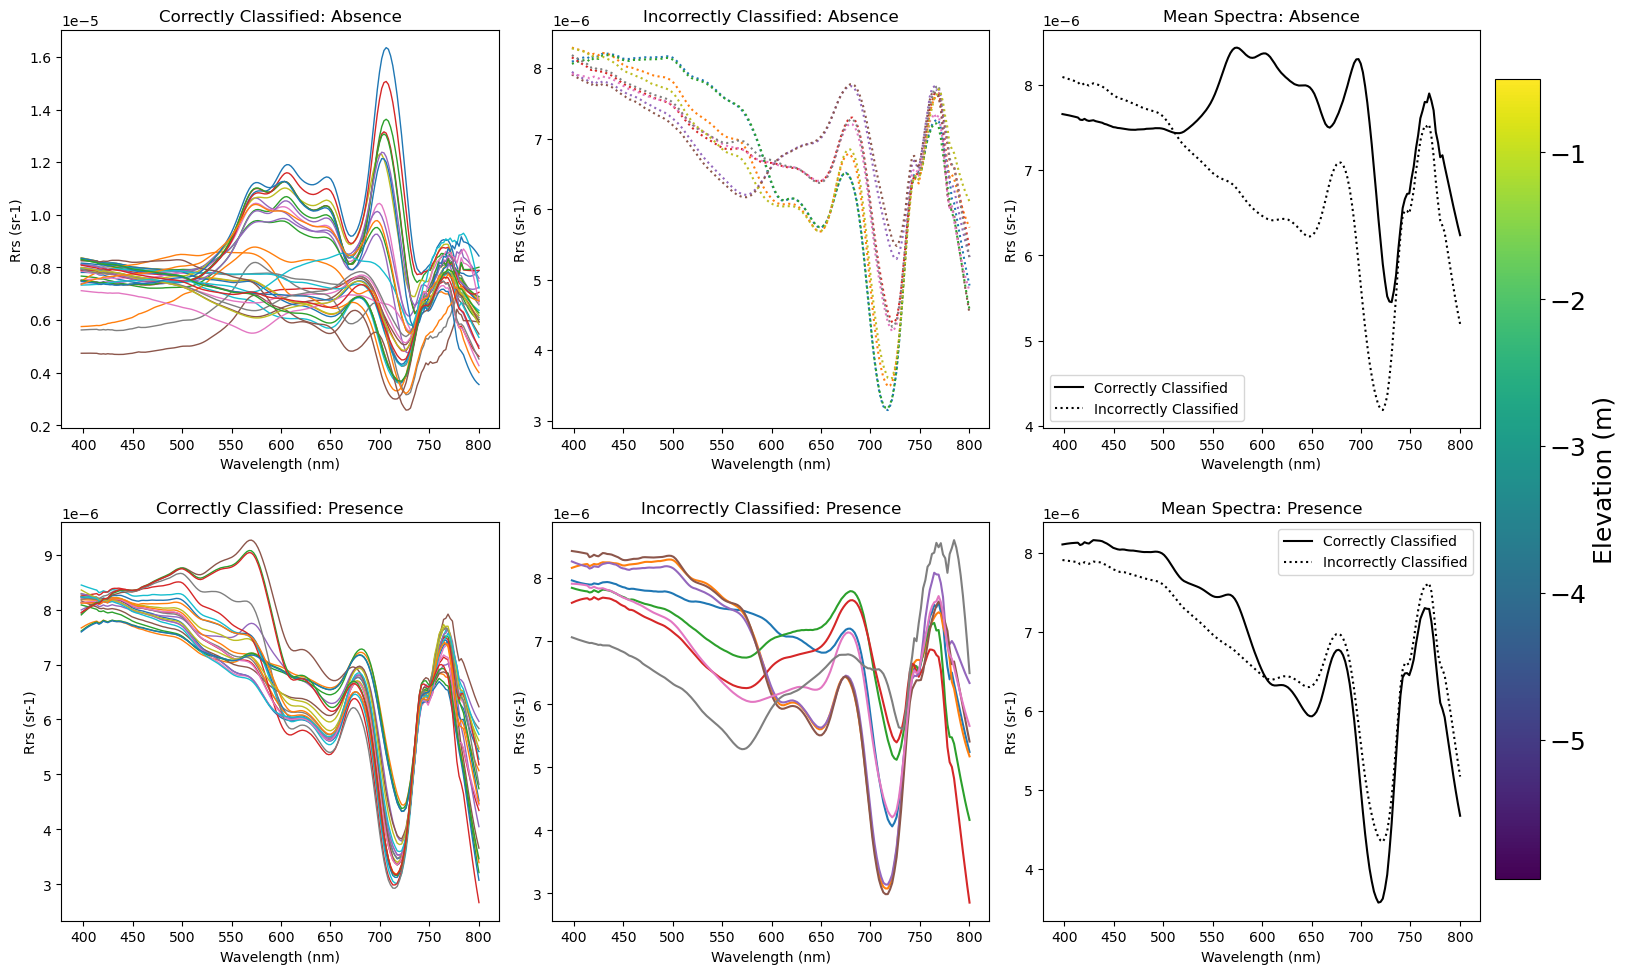

In [160]:
# Create a DataFrame with true labels, predicted labels, and features
results_df = pd.DataFrame({
    'Name': sacfor_data['Name'][val_names.tolist()],
    'True_Label': val_y,
    'Predicted_Label': pred_label,
     'Depth': np.nan #val_X[:, -3]
    # Add other features if needed
})

# Add a column indicating whether the prediction was correct
results_df['Correctly_Classified'] = results_df['True_Label'] == results_df['Predicted_Label']
results_df['Label_Difference'] = results_df['True_Label'] - results_df['Predicted_Label']
results_df.reset_index(inplace=True)

num_classes = 2
label = ['Absence','Presence']
# label = ['Low', 'Moderate', 'Dense']

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(num_classes, 3, figsize=(15, 5 * num_classes))

# create a ScalarMappable object for the color mapping
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=sacfor['Elev(m)'].min(), vmax=sacfor['Elev(m)'].max())

for val in range(num_classes):
    print(val)
    
    # Extract indices of correctly and incorrectly classified samples
    correct_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==True)].index
    incorrect_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==False)].index
    
    # Access corresponding features for correctly and incorrectly classified samples
    correctly_classified = val_X[correct_indices].T#[:-3]
    incorrectly_classified = val_X[incorrect_indices].T#[:-3]
    incorrectly_classified_val = results_df['Label_Difference'][incorrect_indices]
    depth = results_df['Depth'][correct_indices]
    
    correctly_classified_mean = np.mean(correctly_classified,axis=1)
    incorrectly_classified_mean = np.mean(incorrectly_classified,axis=1)

    '''
    plot it in a grid for each class where each row has three columns with 
    1. the correctly classified spectra (no color specification) 
    
    2. the incorrectly classified spectra (shade is based on sign value, 
    color is based on magnitude)
    
    3. the mean of the correctly and incorrectly labeled spectra (black solid for correct, 
    black dashed for incorrect)
    
    '''
    
    # Plotting the correctly classified spectra
    for e,el in enumerate(depth):
        # axes[val, 0].plot(wl['wl'], correctly_classified[:,e], linewidth = 1,color=cmap(norm(el)))
        axes[val, 0].plot(wl['wl'], correctly_classified[:,e], linewidth = 1)
    # axes[val, 0].plot(wl['wl'],correctly_classified,color=cmap(norm(depth)))
    axes[val, 0].set_title(f'Correctly Classified: {label[val]}')
    # axes[val, 0].set_ylim([0,0.015])
    axes[val, 0].set_xlabel('Wavelength (nm)')
    axes[val, 0].set_ylabel('Rrs (sr-1)')

    # Plotting the incorrectly classified spectra
    # axes[val, 1].plot(wl['wl'],incorrectly_classified, color=cmap(norm(el)))
    axes[val, 1].plot(wl['wl'],incorrectly_classified)
    
    # Customize line colors based on 'incorrectly_classified_val' sign
    for l,line in enumerate(axes[val, 1].lines):
        if incorrectly_classified_val.iloc[l] < 0:
            line.set_linestyle(':')
        else:
            line.set_linestyle('-')
    
    # update plot settings        
    axes[val, 1].set_title(f'Incorrectly Classified: {label[val]}')
    # axes[val, 1].set_ylim([0,0.015])
    axes[val, 1].set_xlabel('Wavelength (nm)')
    axes[val, 1].set_ylabel('Rrs (sr-1)')
    #axes[val, 1].legend(['overclassified','underclassified'])
    



    # Plotting the mean of correctly and incorrectly labeled spectra
    axes[val, 2].plot(wl['wl'],correctly_classified_mean, label='Correctly Classified',color='k')
    axes[val, 2].plot(wl['wl'],incorrectly_classified_mean, label='Incorrectly Classified',color='k',linestyle=':')
    # axes[val, 2].set_ylim([0,0.015])
    axes[val, 2].set_xlabel('Wavelength (nm)')
    axes[val, 2].set_ylabel('Rrs (sr-1)')
    axes[val, 2].set_title(f'Mean Spectra: {label[val]}')
    axes[val, 2].legend()

# add the colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.1, 0.03, 0.8])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Elevation (m)',fontsize=18)
cbar_ax.tick_params(labelsize=18)  

plt.tight_layout()
plt.show()

# save the fig
fig.savefig(f'output/kelp/{datestring}_kelp_{class_str}_check_{file_str}.jpg')    

# save the results DF
results_df.to_csv(f'output/kelp/{datestring}_kelp_{class_str}_check_{file_str}.csv')


### Predicting the rest of the image

In [150]:
predict_var = brf
score_var = score_brf

In [171]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
# use flattened_data var from above

# Now predict for each pixel
kelp_prediction = predict_var.predict(flattened_data)

# Reshape our classification map
kelp_prediction_reshape = kelp_prediction.reshape(arr_clean[0,:, :].shape)

# mask bare substrate
kelp_prediction_mask = np.ma.masked_array(kelp_prediction_reshape, mask=vegmask)

# mask deep water
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_reshape, mask=zmask)



# # mask missing sidescan data
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_mask, mask=np.tile(nanmask_slope, (1,1,1)))
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_mask, mask=np.tile(nanmask_rug, (1,1,1)))

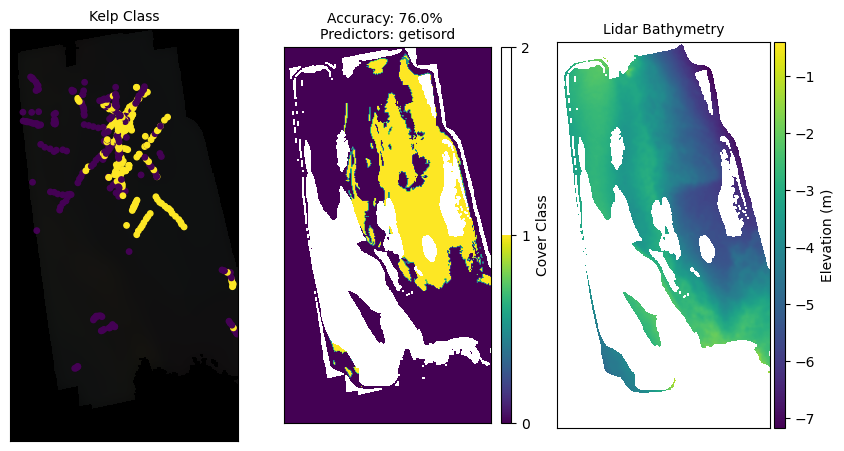

In [172]:
# See https://github.com/matplotlib/matplotlib/issues/844/
n = kelp_prediction.max()

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting

# full spectral resolution
corr_rgb = arr_subset_nanmasked[[114, 75, 25], :, :]


gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(10, 8))

show(gamma_corrected, 
     transform = rio.windows.transform(subset_window, src.transform), 
     ax=ax1)
ax1.set_title('Kelp Class',fontsize=10)
sacfor_data.plot(ax=ax1, 
                        c=sacfor_data['kelp_pres/'], 
                        markersize=15)
ax1.set_xticks([])
ax1.set_yticks([])

pred_im = show(kelp_prediction_mask,
                transform = rio.windows.transform(subset_window, src.transform),
                ax=ax2)
im_class = pred_im.get_images()[0]
ax2.set_title(f'Accuracy: {score_var:.1f}% \nPredictors: {file_str}',fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])

# resize the colorbar to match the size of ax2
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad=0.1)
cbar = fig.colorbar(im_class, 
                    cax=cax, 
                    cmap='viridis')
cbar.ax.tick_params(labelsize=10)
# #cbar.set_ticks([0,1,2,3,4,5])
cbar.set_ticks([0,1,2])
# cbar.set_ticks([0,1])
cbar.set_label('Cover Class')

rio_im = show(bathy_vegmask, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              ax=ax3,
              cmap='viridis')
im = rio_im.get_images()[0]
ax3.set_title('Lidar Bathymetry',fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


fig.savefig(f'output/kelp/{datestring}_kelp_{class_str}_class_{file_str}.jpg')
plt.show()